<a href="https://colab.research.google.com/github/korayyalpp/korayalp-Koray-Alp-DSA210/blob/main/dsa-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset - 2020-09-24.csv to dataset - 2020-09-24.csv


In [2]:
import pandas as pd

df = pd.read_csv("dataset - 2020-09-24.csv")

# Keep relevant columns
df = df[['Name', 'Position', 'Yellow cards', 'Red cards']].copy()

# Create card_score
df['card_score'] = df['Yellow cards']*2 + df['Red cards']*3

df.head()

,Name,Position,Yellow cards,Red cards,card_score
0,Bernd Leno,Goalkeeper,2,0,4
1,Matt Macey,Goalkeeper,0,0,0
2,Rúnar Alex Rúnarsson,Goalkeeper,0,0,0
3,Héctor Bellerín,Defender,23,0,46
4,Kieran Tierney,Defender,2,0,4


In [3]:
x = 10  #
df['label_high'] = (df['card_score'] >= x).astype(int)
df['label_high'].value_counts()

,count
label_high,
0,312
1,259


In [4]:
x = df['card_score'].quantile(0.75)
x = int(round(x))
print("Chosen threshold x =", x)

df['label_high'] = (df['card_score'] >= x).astype(int)
df['label_high'].value_counts()

Chosen threshold x = 22


,count
label_high,
0,418
1,153


In [5]:
from sklearn.model_selection import train_test_split

X = df[['Position']].copy()         # ONLY position as feature
y = df['label_high'].copy()

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split temp into 15% val and 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train label counts:\n", y_train.value_counts(normalize=True))

Train: (399, 1) Val: (86, 1) Test: (86, 1)
Train label counts:
 label_high
0    0.73183
1    0.26817
Name: proportion, dtype: float64


In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

preprocess = ColumnTransformer(
    transformers=[
        ("pos", OneHotEncoder(handle_unknown="ignore"), ["Position"])
    ]
)

models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42),
    "DecisionTree": DecisionTreeClassifier(max_depth=4, class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=6, class_weight="balanced", random_state=42
    )
}

In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def eval_model(pipe, X, y, name=""):
    probs = pipe.predict_proba(X)[:, 1]
    preds = (probs >= 0.5).astype(int)

    out = {
        "model": name,
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, zero_division=0),
        "recall": recall_score(y, preds, zero_division=0),
        "f1": f1_score(y, preds, zero_division=0),
        "roc_auc": roc_auc_score(y, probs),
    }
    return out

val_results = []

trained_pipes = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    trained_pipes[name] = pipe
    val_results.append(eval_model(pipe, X_val, y_val, name))

val_df = pd.DataFrame(val_results).sort_values(by="f1", ascending=False)
val_df

,model,accuracy,precision,recall,f1,roc_auc
0,LogReg,0.511628,0.344262,0.913043,0.5,0.661491
1,DecisionTree,0.511628,0.344262,0.913043,0.5,0.661491
2,RandomForest,0.511628,0.344262,0.913043,0.5,0.661491


In [8]:
best_name = val_df.iloc[0]["model"]
best_pipe = trained_pipes[best_name]

print("Best model based on validation F1:", best_name)

test_metrics = eval_model(best_pipe, X_test, y_test, best_name)
test_metrics

Best model based on validation F1: LogReg


{'model': 'LogReg',
 'accuracy': 0.5465116279069767,
 'precision': 0.35714285714285715,
 'recall': 0.8695652173913043,
 'f1': 0.5063291139240507,
 'roc_auc': np.float64(0.6249137336093857)}

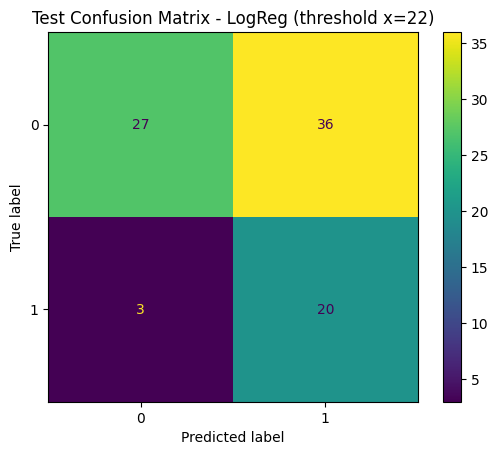

Threshold x = 22
Positive class means: card_score >= x


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

probs = best_pipe.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Test Confusion Matrix - {best_name} (threshold x={x})")
plt.show()

print("Threshold x =", x)
print("Positive class means: card_score >= x")